## Download raw and reference data and upload trained model

In [ ]:
! wget --header="Host: doc-14-18-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Cookie: AUTH_dp1l4faf6942l4710tsq85u12bcjudim=00838855734384147432|1683508650000|edrsjqda5q4t3ge5t6i4bs9v1btj6bjh" --header="Connection: keep-alive" "https://doc-14-18-docs.googleusercontent.com/docs/securesc/u8b87l5l6471r2lqtn6669a7q1d31ilr/8661fkqg6gd6i0ed649jhcureb7vs7ml/1683508650000/15732550580278023123/00838855734384147432/10kvDfgTc44SyadYW4YuKsa_tXuPWvrCx?e=download&ax=ADWCPKAded2vYUdZ6iditbvjEuC6xzIZbApTvipV9K0jkRpjTyr-b7OyepAN7Jh5aZsq9Uo_Po-ksURGsjZGLrTCHzYaagO_UYDNL8iA3XIkXaOdrr3rP39F4L7qq5nhIr375Zlm91HpnsBUzm2FxyDDyrFqhQle37c9lfBNZtTISM0C4wda9hNrXv9KMYW7PzetLQLUEEHOjcnlHoKIehUJNfjYHT1GRY-vpFbHd3GMMKHJ_ziemIEstLHVZLA1hamWGGGF6B1ZGDjfUVIPUhwXD6p3Y9PpSX1bmEK9wMRJlpGTfg2oQ_ZSt7LyHagVWW9CPE_gmNI2AIXkurgNtXdyfScndsuFthkQ978k5eIFsmhGHcZhT8_rN-XogbijUfs1ZMetdjR8HUYMeo2mTELEltisE1VKBCq5Mgd3eyzQmtJFG0iKWP3EFlV_rOFtaFJbaCz5CebLK7Lk3_UcJzip3dSsLzhAcFB0_NhSG07o38epfT-RS_AejA5oY7sTQEoHXhTsZS7Js5sE-TI7PztEmm1vcn3GnVU9EOmIcTN6vWDPSihG0LMEO6XH3XYUalaU-9IGPujlAaJ5ldIlEKRLr0PiAIRArfhKZhFpH6A-_Y1xoUI6TQoCXUrVqOcs2FN76HKiTezpJEgyP0WgYebRPx_OJd1EULx0BwIcue1t7q0oHLjHk1l9e_gcNgI5hUjc3pXCVOB-SUBP0kCPWsKBVxEL4rdbMXOC6PcN8Ly4KZqJbRc6PIfviVOUjwdmKu_LV4EfDSan23XQo8ITwIEk1BpkCUtPZLkE3hBrkxcqJ_anUWR_sji-hL76cPqTiiJSv0O2BicfF33dyOOcnvZ2fQTPCVQSqyj9hf2rAWOTZcVwukkUGdUNViNT_4KE9U8&uuid=94047a93-c4e3-45d1-86ee-eba718fb1ec7&authuser=0" -c -O 'reference_uieb.zip'

In [ ]:
! pip install tensorflow-addons
! unzip /content/raw_uieb.zip
! unzip /content/reference_uieb.zip
! rm -r /content/__MACOSX

## Import libraries

In [4]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import UpSampling2D
# from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import tensorflow_addons as tfa
from tensorflow_addons.image import gaussian_filter2d
from sklearn.model_selection import train_test_split
K.set_image_data_format('channels_last')
import os
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import pandas as pd
import numpy as np
import cv2
import cv2 as cv
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Train Statistically driven UWCNN

In [5]:
optim = tf.keras.optimizers.Adam(0.002)

class Customloss(tf.keras.losses.Loss):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)
    self.mse = tf.keras.losses.MeanSquaredError()
  def call(self,y_true, y_pred):
    lmse=self.mse(y_true, y_pred)
    ssim =tf.image.ssim(y_true,y_pred, max_val=1, filter_size=13,filter_sigma=1.5, k1=0.02, k2=0.03)
    return lmse+(1-ssim)

In [6]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self,  filters=16, stride=1,**kwargs):
        super().__init__(**kwargs)
        self.F1= filters
        self.stride = stride
        self.conv1= tf.keras.layers.Conv2D(self.F1, (3,3), padding='same',strides=self.stride,kernel_initializer=glorot_uniform(seed=0))
        self.conv2= tf.keras.layers.Conv2D(self.F1, (3,3), padding='same',strides=self.stride,kernel_initializer=glorot_uniform(seed=0))
        self.conv3= tf.keras.layers.Conv2D(self.F1, (3,3), padding='same',strides=self.stride,kernel_initializer=glorot_uniform(seed=0))
    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.F1,
            'stride': self.stride
        })
        return config
    def call(self, input_tensor):
        # write the architecutre that was mentioned above
        x= self.conv1(input_tensor)
        x_one= tf.nn.relu(x)
        x = self.conv2(x_one)
        x_two= tf.nn.relu(x)
        x = self.conv3(x_two)
        x_three= tf.nn.relu(x)
        x = tf.concat([x_one,x_two,x_three],axis=-1)
        return x

In [7]:
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.val_loss=[]
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])

In [8]:
class Sharpen(tf.keras.layers.Layer):
    def __init__(self, num_outputs, trainable=True, kernel=None, **kwargs):
        super(Sharpen, self).__init__(**kwargs)
        self.num_outputs = num_outputs
        self.trainable = trainable
        self.kernel = kernel

        if self.kernel is None:
            self.kernel = tf.Variable([[[[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]]], dtype=tf.float32)

        self.num_outputs_var = tf.Variable(self.num_outputs, dtype=tf.float32, trainable=True)

    def build(self, input_shape,kernel=None, num_outputs_var=None):
        if kernel is not None:
            self.kernel = kernel
        kernel = tf.math.l2_normalize(self.kernel, axis=[0, 1, 2])
        self.kernel = self.add_weight(
            name='kernel',
            shape=(1, 1, 3, 3),
            initializer=tf.keras.initializers.Constant(kernel.numpy()),
            trainable=True
        )
        if num_outputs_var is not None:
            self.num_outputs_var = num_outputs_var
        self.num_outputs_var = self.add_weight(
            name='num_outputs',
            shape=(),
            initializer=tf.keras.initializers.Constant(self.num_outputs),
            trainable=True
        )

        super(Sharpen, self).build(input_shape)

    def call(self, inputs):
        blurred = gaussian_filter2d(inputs, sigma=10.0, filter_shape=[3, 3])
        unsharp_mask = tf.clip_by_value(inputs + (inputs - blurred) * self.num_outputs_var, 0, 1)
        return unsharp_mask

    def get_config(self):
        config = super(Sharpen, self).get_config()
        config.update({
            'num_outputs': self.num_outputs,
            'trainable': self.trainable,
            'kernel': self.kernel.numpy()
        })
        return config


In [9]:
class ContrastStretchingLayer(tf.keras.layers.Layer):
    def __init__(self, trainable=True, **kwargs):
        super(ContrastStretchingLayer, self).__init__(**kwargs)
        self.trainable = trainable

    def build(self, input_shape):
        if self.trainable:
            self.initial_population = self.add_weight(shape=(4,), initializer=tf.keras.initializers.RandomUniform(minval=0.05, maxval=0.5), trainable=True)
        else:
            self.initial_population = (tf.random.uniform(shape=(4,), minval=0.01, maxval=0.5))
        self.sharpen_layer = Sharpen(num_outputs=1, trainable=True, kernel=None)
        super(ContrastStretchingLayer, self).build(input_shape)

    def call(self, inputs, training=None):
        imgg = differential_evolution_contrast_stretching(inputs, self.initial_population )
        sharpened_image = self.sharpen_layer(tf.expand_dims(imgg, axis=0))
        return sharpened_image

    def get_config(self):
        config = super(ContrastStretchingLayer, self).get_config()
        config.update({"trainable": self.trainable})
        return config


## Modified diff evo

In [10]:
def differential_evolution_contrast_stretching(image,initial_population):
    image = tf.cast(image, tf.float32)
    population_size = 4
    initial_population = (tf.random.uniform(shape=(population_size,), minval=0.01, maxval=0.5))
    def obj_func(x, channel):
        c = tfp.stats.percentile(channel, 1.0)
        d = tfp.stats.percentile(channel, 99.0)
        value = (channel - c)
        value = tf.tile(tf.expand_dims(value, axis=-1), multiples=[1, 1, population_size])
        value = tf.cast(value, tf.float32)
        c = tf.cast(c, tf.float32)
        d = tf.cast(d, tf.float32)
        stretched_channel = value * (((1 - x) - x) / (d - c)) + x
        stretched_channel = tf.clip_by_value(stretched_channel, 0, 1)
        avg_gradients = []
        entropies = []
        for i in range(population_size):
            avg_gradient = tf.reduce_mean(tf.abs(tf.image.image_gradients(tf.expand_dims(stretched_channel[:, :, i:i+1], axis=0))))
            avg_gradients.append(avg_gradient)
            # float_tensor = tf.constant(stretched_channel[:, :, i:i+1], dtype=tf.float32)
            float_tensor=stretched_channel[:, :, i:i+1]
            histogram = tf.histogram_fixed_width(float_tensor, [0.0, 1.0], nbins=256)
            probabilities = histogram / tf.reduce_sum(histogram)
            entropy = tf.reduce_sum(-tf.math.log(probabilities + 1e-10) * probabilities)
            entropies.append(entropy)
        f = (-1 * (tf.stack(avg_gradients) + tf.cast(tf.stack(entropies), tf.float32)))
        return f

    channels = tf.unstack(image, axis=-1)
    stretched_channels = []
    for channel in channels:
        channel= tf.reshape(channel, shape=(256, 256))
        optim_results = tfp.optimizer.differential_evolution_minimize(
            lambda x: obj_func(x, channel/255.0),
            initial_population=initial_population,
            seed=43210
        )
        x_opt = optim_results.position
        c = tfp.stats.percentile(channel, 1.0)
        d = tfp.stats.percentile(channel, 99.0)
        value = (channel - c)
        value = tf.cast(value, tf.float32)
        c = tf.cast(c, tf.float32)
        d = tf.cast(d, tf.float32)
        stretched_channel = value * (((1 - x_opt) - x_opt) / (d - c)) + x_opt
        stretched_channel = tf.clip_by_value(stretched_channel, 0, 1)
        stretched_channels.append(stretched_channel)
    return tf.stack(stretched_channels, axis=-1)


## Model

In [11]:
im1     = Input(shape=(256,256,3))
conv    = convolutional_block(16,1)(im1)
concat1 = tf.concat([im1,conv],axis=-1)
conv2   = convolutional_block(16,1)(concat1)
concat2 = tf.concat([im1,conv2,concat1],axis=-1)
conv3   = convolutional_block(16,1)(concat2)
concat3 = tf.concat([im1,conv3,concat2],axis=-1)
conv2D  = Conv2D(3, (3, 3), padding="same", kernel_initializer=glorot_uniform(seed=0))(concat3)
output  = tf.add(conv2D,im1)
output  = ContrastStretchingLayer()(output)

In [12]:
model = Model(inputs = im1, outputs = output)
loss_history = LossHistory()

model.compile(optim, loss=Customloss())
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 convolutional_block (convoluti  (None, 256, 256, 48  5088       ['input_1[0][0]']                
 onal_block)                    )                                                                 
                                                                                                  
 tf.concat (TFOpLambda)         (None, 256, 256, 51  0           ['input_1[0][0]',                
                                )                                 'convolutional_block[0][0]']

In [13]:
def return_file_names_df(root_dir,folder):
    filenames_img=[]
    filenames_mask=[]
    files=os.listdir(root_dir)
    path1=root_dir+'/'+'raw_uieb/'+folder
    path2=root_dir+'/'+'reference_uieb/'+folder
    for i in sorted(os.listdir(path1)):
      if i.split('/')[-1][:2]!='._':
        filenames_img.append(path1+'/'+str(i))
    for i in sorted(os.listdir(path2)):
      if i.split('/')[-1][:2]!='._':
        filenames_mask.append(path2+'/'+str(i))
    data_df=pd.DataFrame(list(zip(filenames_img, filenames_mask)),
              columns=['image','enhanced_image'])
    return data_df

In [14]:
X_train=return_file_names_df('/content','train')
X_valid=return_file_names_df('/content','valid')
X_test=return_file_names_df('/content','test')

In [15]:
class Dataset:
  def __init__(self, data_df1):
        self.data = data_df1
        # the paths of images
        self.images_fps   = list(self.data['image'].values)
        # the paths of segmentation images
        self.masks_fps    = list(self.data['enhanced_image'].values)

  def __getitem__(self, i):
        # read data
        im_image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        im_enhanced = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)

        #calculate the 50 percent of original dimensions
        width  = 256
        height = 256

        # dsize
        dsize = (width, height)

        # resize image
        im_image   = cv2.resize(im_image, dsize,interpolation=cv2.INTER_NEAREST)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        im_enhanced = cv2.resize(im_enhanced,dsize,interpolation=cv2.INTER_NEAREST)

        return im_image/255.0,im_enhanced/255.0
        
  def __len__(self):
        return len(self.data)
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [16]:
# Dataset for train images
train_dataset = Dataset(X_train)
valid_dataset = Dataset(X_valid)
test_dataset  = Dataset(X_test)

BATCH_SIZE=1
train_dataloader = Dataloder(train_dataset, batch_size=1, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert test_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, 3)

(1, 256, 256, 3)


In [17]:
# define callbacks
save_best_cp = ModelCheckpoint(
    filepath='Uwcnn_trainableDE_UIEBbest_model.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=4, 
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1
)

history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=50,validation_data=valid_dataloader,callbacks=[loss_history,save_best_cp, reduce_lr, early_stop])

Epoch 1/50


720/720 [==============================] - ETA: 0s - loss: 0.1358
Epoch 1: val_loss improved from inf to 0.12269, saving model to Uwcnn_trainableDE_UIEBbest_model.h5
720/720 [==============================] - 661s 872ms/step - loss: 0.1358 - val_loss: 0.1227 - lr: 0.0020
Epoch 2/50
720/720 [==============================] - ETA: 0s - loss: 0.1399
Epoch 2: val_loss did not improve from 0.12269
720/720 [==============================] - 625s 868ms/step - loss: 0.1399 - val_loss: 0.1310 - lr: 0.0020
Epoch 3/50
720/720 [==============================] - ETA: 0s - loss: 0.1317
Epoch 3: val_loss improved from 0.12269 to 0.11229, saving model to Uwcnn_trainableDE_UIEBbest_model.h5
720/720 [==============================] - 622s 864ms/step - loss: 0.1317 - val_loss: 0.1123 - lr: 0.0020
Epoch 4/50
720/720 [==============================] - ETA: 0s - loss: 0.1352
Epoch 4: val_loss did not improve from 0.11229
720/720 [==============================] - 632s 878ms/step - loss: 0.1352 - val_loss: 0

In [18]:
losses = loss_history.losses
vlosses = loss_history.val_loss

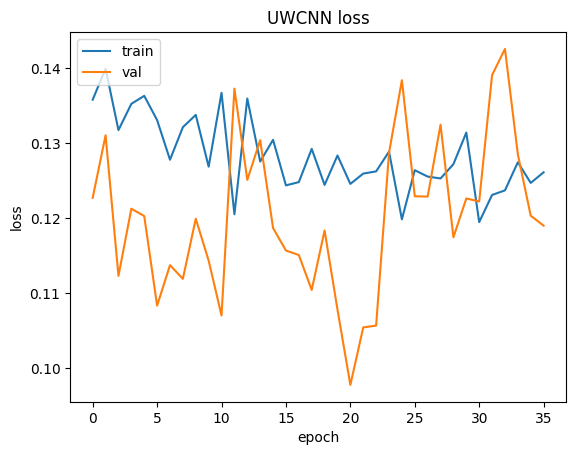

In [19]:
plt.plot(losses)
plt.plot(vlosses)
plt.title('UWCNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('UWCNNLoss.png', dpi=300)
plt.show()

In [ ]:
model.save('Imp_UWCNN_UIEB.h5')

In [20]:
custom_objects = {'ContrastStretchingLayer': ContrastStretchingLayer,
                  'convolutional_block': convolutional_block,
                  'Customloss': Customloss}

In [21]:
Imp_uwcnn=tf.keras.models.load_model('/content/Uwcnn_trainableDE_UIEBbest_model.h5', custom_objects=custom_objects)

## Test Statistically driven UWCNN

In [ ]:
def get_newpath(img_path):
  lists=img_path.split('/')
  lists[2]='enhanced_images'
  img_path='/'.join(lists)
  return img_path

In [ ]:
for img_array in test_dataloader:
  cv.imwrite('/content/original.jpg',np.uint8(img_array[0][0]*255))
  cv.imwrite('/content/enhanced.jpg',np.uint8(img_array[1][0]*255))
  

In [ ]:
from IPython.display import Image
Image(filename='/content/original.jpg')

In [22]:
MSE=[]
SSIM=[]
PSNR=[]
count=0
for img_array in test_dataloader:
  image1= tf.cast(img_array[0], tf.float32) 
  image2= tf.cast(img_array[1], tf.float32) 
  image1=Imp_uwcnn.predict(image1)
  img_pred=image1[0]*255
  mse  = tf.reduce_mean(tf.square(image1 - image2))
  ssim = tf.image.ssim(image1, image2, max_val=1.0)
  psnr = tf.image.psnr(image1, image2, max_val=1.0)
  MSE.append(mse.numpy())
  SSIM.append(ssim.numpy())
  PSNR.append(psnr.numpy())

1/1 [==============================] - 1s 507ms/step


In [23]:
print(np.average(MSE)*255*255) 
print(np.average(SSIM)) 
print(np.average(PSNR))

923.9572071935982
0.877737
19.815123


In [ ]:
len(PSNR)

90

## Visual Test 

In [ ]:
! wget --header="Host: doc-14-18-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Cookie: AUTH_dp1l4faf6942l4710tsq85u12bcjudim_nonce=42v9go92jade6" --header="Connection: keep-alive" "https://doc-14-18-docs.googleusercontent.com/docs/securesc/u8b87l5l6471r2lqtn6669a7q1d31ilr/nce241v8ap7c7n7ljm6ui0cbj94n8gsi/1683536400000/15732550580278023123/00838855734384147432/1cjz_NFnoNnEFCAFcMZ_IlPv8p2FExZwZ?e=download&ax=ADWCPKAmbhclScglhGCPoIt1152XIr34iS_sjVpmp3Cdgfgvwcbi2p8Gl6KfWZqjwUJ3hzX_pnzrVrBbEtUUJcagUk-eauPOGdWy6QVW0qAAwsibXOMIKDA_fqWQF8l8oOUGBWbs9OKTSQ_se_RJC0I9yrsMvUGF6V5SyTxX7PQHqqaC9c0ML9ic3eiiP4ftQ0WsNxL-P_5QABgbacufHEU_0m-k2ZYjflC3frvoD2MdixEOfv5c7E2ok7097YA_OfShMHQfjhOQ2Z3OEeIIvVTrIvfp_3VBYfN49g0J7woaFprgPku5HnfIDW-DP1NJTbWMrV8SZS7J4nqNhU6Qhs-nC5qjaroT7-TbHAix1PBr8d9bWsxXDJBfQqblOvnQSVaw0oBeu8G9UpfAXehkyfS3l8bmQxKDdfos3mUWD4GdHQthO0X4J-kyluoj7aSItFTiP2T9Vqa1CiPQ0HmWYuDkvmKGItSy_CHnLykcV_K0_e6nmC1jO4vWFTOXS-4bPc5vNm8ltYyUHSpKVYkMcXTf8grz0IikGWuIzt8mQOWcMdo6lHwsLR-MTIW7HAYSqXsE5o4g-JyKhmnswk1ErBj3jkOgvEKrdQiajHYO4IVkeo35YyennlDAjm0sg5YIX-uPxVhZJjHKvg1MsqMQzH_p0TMPKZRnqdhfVpClttpKf2wOK7CfcIt8_xJ_Css-4sYQn6VGtlqhj2HyAnEXyJvQcFcR_UtJ0_gAYXfboAe_Fquafz8e8b0kDuGgi9je6Rv4_zIW1pZe0XO6PDgP-PjX-huHUaSIqkBc7zgVZCBZiDYzKQwp3bqRFpJMq6clTt-neIAUjK7JiosULHQmuy1ZyWuCpEijORR2tex2GMYD-2QjM1J3PWZusLZlEsvdzc0&uuid=10594b7f-d53c-407c-9bc1-f78930238aff&authuser=0&nonce=42v9go92jade6&user=00838855734384147432&hash=vpvn9a2b0jmdc9eeqh6rntctjb6k9c3p" -c -O 'challenging-60.zip'

In [ ]:
! unzip /content/challenging-60.zip

In [27]:
count=0
for img_path in os.listdir('/content/challenging-60'):
  count+=1
  img = cv2.imread('/content/challenging-60/'+img_path)
  img_array = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_array = tf.image.resize(img_array, size=(256, 256))
  img_array=img_array/255.0
  image1= tf.cast(img_array, tf.float32)  
  image1 = tf.expand_dims(image1, axis=0)
  image1=Imp_uwcnn.predict(image1)
  img_pred=image1[0]*255
  cv.imwrite('/content/output/img_'+str(count)+'.jpg',np.uint8(img_pred))


1/1 [==============================] - 0s 304ms/step


In [26]:
from scipy import ndimage
from PIL import Image
import numpy as np
import math

def mu_a(x, alpha_L=0.1, alpha_R=0.1):
    """
      Calculates the asymetric alpha-trimmed mean
    """
    # sort pixels by intensity - for clipping
    x = sorted(x)
    # get number of pixels
    K = len(x)
    # calculate T alpha L and T alpha R
    T_a_L = math.ceil(alpha_L*K)
    T_a_R = math.floor(alpha_R*K)
    # calculate mu_alpha weight
    weight = (1/(K-T_a_L-T_a_R))
    # loop through flattened image starting at T_a_L+1 and ending at K-T_a_R
    s   = int(T_a_L+1)
    e   = int(K-T_a_R)
    val = sum(x[s:e])
    val = weight*val
    return val

def s_a(x, mu):
    val = 0
    for pixel in x:
        val += math.pow((pixel-mu), 2)
    return val/len(x)

def _uicm(x):
    R = x[:,:,0].flatten()
    G = x[:,:,1].flatten()
    B = x[:,:,2].flatten()
    RG = R-G
    YB = ((R+G)/2)-B
    mu_a_RG = mu_a(RG)
    mu_a_YB = mu_a(YB)
    s_a_RG = s_a(RG, mu_a_RG)
    s_a_YB = s_a(YB, mu_a_YB)
    l = math.sqrt( (math.pow(mu_a_RG,2)+math.pow(mu_a_YB,2)) )
    r = math.sqrt(s_a_RG+s_a_YB)
    return (-0.0268*l)+(0.1586*r)

def sobel(x):
    dx = ndimage.sobel(x,0)
    dy = ndimage.sobel(x,1)
    mag = np.hypot(dx, dy)
    mag *= 255.0 / np.max(mag) 
    return mag

def eme(x, window_size):
    """
      Enhancement measure estimation
      x.shape[0] = height
      x.shape[1] = width
    """
    # if 4 blocks, then 2x2...etc.
    k1 = int(x.shape[1]/window_size)
    k2 = int(x.shape[0]/window_size)
    # weight
    w = 2./(k1*k2)
    blocksize_x = window_size
    blocksize_y = window_size
    # make sure image is divisible by window_size - doesn't matter if we cut out some pixels
    x = x[:int(blocksize_y*k2), :int(blocksize_x*k1)]
    val = 0
    for l in range(k1):
        for k in range(k2):
            block = x[int(k*window_size):int(window_size*(k+1)), int(l*window_size):int(window_size*(l+1))]
            max_ = np.max(block)
            min_ = np.min(block)
            # bound checks, can't do log(0)
            if min_ == 0.0: val += 0
            elif max_ == 0.0: val += 0
            else: val += math.log(max_/min_)
    return w*val

def _uism(x):
    """
      Underwater Image Sharpness Measure
    """
    # get image channels
    R = x[:,:,0]
    G = x[:,:,1]
    B = x[:,:,2]
    # first apply Sobel edge detector to each RGB component
    Rs = sobel(R)
    Gs = sobel(G)
    Bs = sobel(B)
    # multiply the edges detected for each channel by the channel itself
    R_edge_map = np.multiply(Rs, R)
    G_edge_map = np.multiply(Gs, G)
    B_edge_map = np.multiply(Bs, B)
    # get eme for each channel
    r_eme = eme(R_edge_map, 10)
    g_eme = eme(G_edge_map, 10)
    b_eme = eme(B_edge_map, 10)
    # coefficients
    lambda_r = 0.299
    lambda_g = 0.587
    lambda_b = 0.144
    return (lambda_r*r_eme) + (lambda_g*g_eme) + (lambda_b*b_eme)

def plip_g(x,mu=1026.0):
    return mu-x

def plip_theta(g1, g2, k):
    g1 = plip_g(g1)
    g2 = plip_g(g2)
    return k*((g1-g2)/(k-g2))

def plip_cross(g1, g2, gamma):
    g1 = plip_g(g1)
    g2 = plip_g(g2)
    return g1+g2-((g1*g2)/(gamma))

def plip_diag(c, g, gamma):
    g = plip_g(g)
    return gamma - (gamma * math.pow((1 - (g/gamma) ), c) )

def plip_multiplication(g1, g2):
    return plip_phiInverse(plip_phi(g1) * plip_phi(g2))
    #return plip_phiInverse(plip_phi(plip_g(g1)) * plip_phi(plip_g(g2)))

def plip_phiInverse(g):
    plip_lambda = 1026.0
    plip_beta   = 1.0
    return plip_lambda * (1 - math.pow(math.exp(-g / plip_lambda), 1 / plip_beta));

def plip_phi(g):
    plip_lambda = 1026.0
    plip_beta   = 1.0
    return -plip_lambda * math.pow(math.log(1 - g / plip_lambda), plip_beta)

def _uiconm(x, window_size):
    """
      Underwater image contrast measure
      https://github.com/tkrahn108/UIQM/blob/master/src/uiconm.cpp
      https://ieeexplore.ieee.org/abstract/document/5609219
    """
    plip_lambda = 1026.0
    plip_gamma  = 1026.0
    plip_beta   = 1.0
    plip_mu     = 1026.0
    plip_k      = 1026.0
    # if 4 blocks, then 2x2...etc.
    k1 = int(x.shape[1]/window_size)
    k2 = int(x.shape[0]/window_size)
    # weight
    w = -1./(k1*k2)
    blocksize_x = window_size
    blocksize_y = window_size
    # make sure image is divisible by window_size - doesn't matter if we cut out some pixels
    x = x[:int(blocksize_y*k2), :int(blocksize_x*k1)]
    # entropy scale - higher helps with randomness
    alpha = 1
    val = 0
    for l in range(k1):
        for k in range(k2):
            block = x[k*window_size:window_size*(k+1), l*window_size:window_size*(l+1), :]
            max_ = np.max(block)
            min_ = np.min(block)
            top = max_-min_
            bot = max_+min_
            if math.isnan(top) or math.isnan(bot) or bot == 0.0 or top == 0.0: val += 0.0
            else: val += alpha*math.pow((top/bot),alpha) * math.log(top/bot)
            #try: val += plip_multiplication((top/bot),math.log(top/bot))
    return w*val

def getUIQM(x):
    """
      Function to return UIQM to be called from other programs
      x: image
    """
    x = x.astype(np.float32)
    ### UCIQE: https://ieeexplore.ieee.org/abstract/document/7300447
    #c1 = 0.4680; c2 = 0.2745; c3 = 0.2576
    ### UIQM https://ieeexplore.ieee.org/abstract/document/7305804
    c1 = 0.0282; c2 = 0.2953; c3 = 3.5753
    uicm   = _uicm(x)
    uism   = _uism(x)
    uiconm = _uiconm(x, 10)
    uiqm = (c1*uicm) + (c2*uism) + (c3*uiconm)
    return [uiqm,uicm,uism,uiconm]


In [28]:
"""
# > Script for measuring quantitative performances in terms of
#    - Structural Similarity Metric (SSIM) 
#    - Peak Signal to Noise Ratio (PSNR)
# > Maintainer: https://github.com/xahidbuffon
"""
## python libs
import numpy as np
from PIL import Image, ImageOps
from glob import glob
from os.path import join
from ntpath import basename
## local libs
# from visual_metrics import getUIQM


def measure_UIQMs(dir_name, im_res=(256, 256)):
    paths = sorted(glob(join(dir_name, "*.*")))
    uqims = []
    uicms=[]
    uisms=[]
    uiconms=[]
    for img_path in paths:
        im = Image.open(img_path).resize(im_res)
        uiqm= getUIQM(np.array(im))
        uqims.append(uiqm[0])
        uicms.append(uiqm[1])
        uisms.append(uiqm[2])
        uiconms.append(uiqm[3])
    return [np.array(uqims),np.array(uicms),np.array(uisms),np.array(uiconms)]

gen_dir = "/content/output/" 
gen_uqims,gen_uicms,gen_uisms,gen_uiconms  = measure_UIQMs(gen_dir)
print ("Enhanced UIQMs >> Mean: {0} std: {1}".format(np.mean(gen_uqims), np.std(gen_uqims)))
print ("Enhanced UICMs >> Mean: {0} std: {1}".format(np.mean(gen_uicms), np.std(gen_uicms)))
print ("Enhanced UISMs >> Mean: {0} std: {1}".format(np.mean(gen_uisms), np.std(gen_uisms)))
print ("Enhanced UICONMs >> Mean: {0} std: {1}".format(np.mean(gen_uiconms), np.std(gen_uiconms)))


Enhanced UIQMs >> Mean: 2.723871562837698 std: 0.4515390101542019
Enhanced UICMs >> Mean: 5.791898953129201 std: 2.1516894647529274
Enhanced UISMs >> Mean: 5.882949352885715 std: 1.6684586722678527
Enhanced UICONMs >> Mean: 0.23027580019922897 std: 0.06366520004521549
